In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization
from tensorflow.keras.layers import Input, Reshape, Dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/zulfauzi92/Hotel_Recomendation_Model_Traveloka/main/Eksplorasi%20Data/Eksperimen/csv_eksperimen/goiboi%2Bdatafiniti_merge_user-collaborative-based.csv'
hotel_train_data = pd.read_csv(url)

In [3]:
hotel_train_data.head(2)

,property_id,user_id,user_rating,user_reviews,property_name,hotel_description,address,point_of_interest,city,state,...,Two Line Telephone,Utensils (on request),Video/ DVD/ CD Player Available,Voicemail.1,Wardrobe,Washing machine,Western Toilet Seat,Window Opens,Work Station,Working Desk Phone
0,H000001,0,4,Staff were helpful and friendly. Wireless inte...,Baragarh Regency,The standard check-in time is 12:00 PM and the...,"15th Mile, N.H.21,Manali, District Kullu,Himac...","['Hadimba Temple', 'Naggar Village', 'Himalaya...",Manali,Himachal Pradesh,...,0,0,0,0,0,0,1,1,0,0
1,H000001,6853,2,Service was fine but the hotel was worn down: ...,Baragarh Regency,The standard check-in time is 12:00 PM and the...,"15th Mile, N.H.21,Manali, District Kullu,Himac...","['Hadimba Temple', 'Naggar Village', 'Himalaya...",Manali,Himachal Pradesh,...,0,0,0,0,0,0,1,1,0,0


In [4]:
df = hotel_train_data[['user_id','property_id','user_rating']]

In [5]:
property= df['property_id']
values = property.values
values

array(['H000001', 'H000001', 'H000001', ..., 'H001431', 'H001432',
       'H001433'], dtype=object)

In [6]:
test = []
for item in range(len(values)):
  #print(values[item])
  test.append(int(values[item][1:]))

In [7]:
np.array(test)

array([   1,    1,    1, ..., 1431, 1432, 1433])

In [8]:
coba = pd.DataFrame(np.array(test))

In [9]:
df['property_id']=coba[0]
df['user_id'] += 1 

In [10]:
df.head(2)

,user_id,property_id,user_rating
0,1,1,4
1,6854,1,2


In [11]:
df['user_rating'] = df['user_rating'] / 5

In [12]:
# df['user_id'] = df['user_id'] / max(df['user_id'])
# df['property_id'] = df['property_id'] / max(df['property_id'])
df

,user_id,property_id,user_rating
0,1,1,0.8
1,6854,1,0.4
2,4633,1,0.8
3,8326,1,0.8
4,2066,2,0.8
...,...,...,...
9743,9094,1429,0.2
9744,9100,1430,1.0
9745,9128,1431,0.8
9746,9171,1432,1.0


In [13]:
df.shape

(9748, 3)

In [14]:
n_users = len(df.user_id.unique())
n_users

9222

In [15]:
n_hotels = len(df.property_id.unique())
n_hotels

1433

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9748 entries, 0 to 9747
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      9748 non-null   int64  
 1   property_id  9748 non-null   int64  
 2   user_rating  9748 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.6 KB


In [17]:
n_users = len(df['user_id'])

n_items = len(df['property_id'])

In [18]:
X = df[['user_id', 'property_id']].values
y = df[['user_rating']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

x_val, x_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)
print(x_val.shape, x_test.shape, y_val.shape, y_test.shape)


(8773, 2) (975, 2) (8773, 1) (975, 1)
(487, 2) (488, 2) (487, 1) (488, 1)


In [19]:
print(max(df['user_id']))

9222


In [20]:
print(max(df['property_id']))

1433


In [21]:
n_factors = 240
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [x_test[:, 0], x_test[:, 1]]
X_val_array = [x_val[:, 0], x_val[:, 1]]

In [52]:
# creating user embedding
user = Input(shape=(1,))
u = Embedding(n_users, 500, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
u = Reshape((500,))(u)

# creating item embedding path
item = Input(shape=(1,))
i = Embedding(n_items, 500, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(item)
i = Reshape((500,))(i)
    
# concatenate features
x = Concatenate()([u, i])
    
# add fully-connected-layers
fc1 = Dense(256, activation='relu')(x)
fc1 = BatchNormalization() (fc1)
fc1 = tf.keras.layers.Dropout(0.1)(fc1)

fc1 = Dense(256, activation='relu')(fc1)
fc1 = BatchNormalization() (fc1)
fc2 = tf.keras.layers.Dropout(0.1)(fc1)

fc2 = Dense(128, activation='relu')(fc2)
fc2 = BatchNormalization() (fc2)
fc2 = tf.keras.layers.Dropout(0.1)(fc2)

fc2 = Dense(128, activation='relu')(fc2)
fc2 = BatchNormalization() (fc2)
fc2 = tf.keras.layers.Dropout(0.1)(fc2)

fc2 = Dense(128, activation='relu')(fc2)
fc2 = BatchNormalization() (fc2)
fc2 = tf.keras.layers.Dropout(0.1)(fc2)

fc2 = Dense(64, activation='relu')(fc2)
fc2 = BatchNormalization() (fc2)
fc2 = tf.keras.layers.Dropout(0.1)(fc2)

fc2 = Dense(64, activation='relu')(fc2)
fc2 = BatchNormalization() (fc2)
fc2 = tf.keras.layers.Dropout(0.1)(fc2)

fc2 = Dense(32, activation='relu')(fc2)
fc2 = BatchNormalization() (fc2)
fc2 = tf.keras.layers.Dropout(0.1)(fc2)

fc2 = Dense(16, activation='relu')(fc2)
fc2 = BatchNormalization() (fc2)
# fc3 = tf.keras.layers.Dropout(0.5)(fc2)
# fc4 = tf.keras.layers.Dropout(0.3)(fc3)
fc2 = tf.keras.layers.Dropout(0.1)(fc2)
out = Dense(1, activation='sigmoid')(fc2)
# mean_absolute_error
model = Model([user, item], out)
opt = tf.keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer = opt, loss = 'mse', metrics=['accuracy'])

In [53]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 500)       4874000     ['input_7[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 500)       4874000     ['input_8[0][0]']                
                                                                                            

In [54]:
history = model.fit(x=X_train_array, y=y_train, batch_size=32, epochs=20,
                    verbose=1, validation_data=(X_val_array, y_val))

Epoch 1/20
275/275 [==============================] - 42s 137ms/step - loss: 0.2043 - accuracy: 0.2472 - val_loss: 0.1755 - val_accuracy: 0.0780
Epoch 2/20
275/275 [==============================] - 38s 137ms/step - loss: 0.1689 - accuracy: 0.2847 - val_loss: 0.1880 - val_accuracy: 0.1622
Epoch 3/20
275/275 [==============================] - 38s 136ms/step - loss: 0.1410 - accuracy: 0.3261 - val_loss: 0.1336 - val_accuracy: 0.2875
Epoch 4/20
275/275 [==============================] - 38s 140ms/step - loss: 0.1193 - accuracy: 0.3656 - val_loss: 0.1049 - val_accuracy: 0.3922
Epoch 5/20
275/275 [==============================] - 37s 136ms/step - loss: 0.1015 - accuracy: 0.4049 - val_loss: 0.0839 - val_accuracy: 0.4353
Epoch 6/20
275/275 [==============================] - 37s 134ms/step - loss: 0.0870 - accuracy: 0.4333 - val_loss: 0.0742 - val_accuracy: 0.4374
Epoch 7/20
275/275 [==============================] - 37s 135ms/step - loss: 0.0777 - accuracy: 0.4556 - val_loss: 0.0626 - val_ac

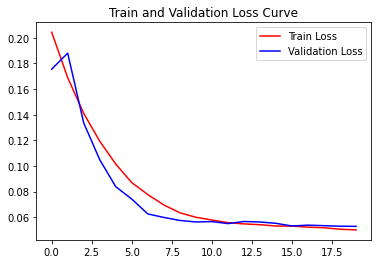

In [55]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

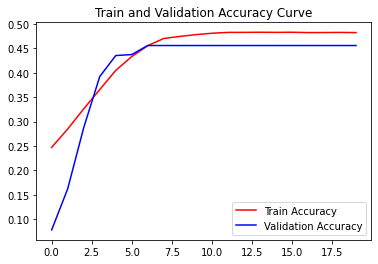

In [56]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(val_acc, color='b', label='Validation Accuracy')
plt.title("Train and Validation Accuracy Curve")
plt.legend()
plt.show()

In [57]:
# Creating dataset for making recommendations for the first user
hotel_data = np.array(list(set(df.property_id)))
hotel_data

array([   1,    2,    3, ..., 1431, 1432, 1433])

In [69]:
user = np.array([1000 for i in range(len(hotel_data))])
user

array([1000, 1000, 1000, ..., 1000, 1000, 1000])

In [70]:
predictions = model.predict([user, hotel_data])

predictions = np.array([a[0] for a in predictions])

recommended_item_ids = (-predictions).argsort()

recommended_item_ids

array([ 39,   6,  66, ...,  27,   7, 236])

In [71]:
# print predicted scores
predictions[recommended_item_ids]

array([0.9933703 , 0.99059904, 0.9873687 , ..., 0.24096206, 0.2393151 ,
       0.2050344 ], dtype=float32)

In [72]:
#Evaluate the model
score = model.evaluate(X_test_array, y_test, verbose=0)
print('Test loss:', score[0])

Test loss: 0.04608462005853653


In [62]:
# print predicted scores
predictions[recommended_item_ids]


array([0.9931544 , 0.99003416, 0.9867308 , ..., 0.24733502, 0.23884082,
       0.20249534], dtype=float32)

In [63]:
predictions = model.predict([user, hotel_data])
predictions = np.array([a[0] for a in predictions])
recommended_hotel_id = (-predictions).argsort()
recommended_hotel_id

array([ 39,   6,  66, ...,  27,   7, 236])

In [64]:
predictions[recommended_hotel_id]

array([0.9931544 , 0.99003416, 0.9867308 , ..., 0.24733502, 0.23884082,
       0.20249534], dtype=float32)

In [65]:
predictions

array([0.7780596 , 0.9014267 , 0.8850441 , ..., 0.7377666 , 0.78334206,
       0.77261186], dtype=float32)